## 1. Importing Necessary Libraries

In [111]:
from pathlib import Path

import numpy as np
import pandas as pd

import sklearn
import xgboost

from sklearn.metrics import r2_score

from sklearn.linear_model import (
      LinearRegression,
      Ridge,
      Lasso
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
      RandomForestRegressor,
      AdaBoostRegressor,
      GradientBoostingRegressor
)
from xgboost import XGBRegressor


from sklearn.base import (
    BaseEstimator,
    TransformerMixin
)

from sklearn.impute import (
    SimpleImputer
)

from sklearn.preprocessing import (
	OneHotEncoder,
    OrdinalEncoder,
    TargetEncoder,
    StandardScaler,
    MinMaxScaler,
    FunctionTransformer
)

from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor
)

from sklearn.pipeline import (
    Pipeline,
    FeatureUnion
)

from feature_engine.encoding import(
    RareLabelEncoder
)

from feature_engine.selection import(
    SelectBySingleFeaturePerformance,
    SmartCorrelatedSelection
)

import optuna
from optuna.visualization import plot_parallel_coordinate
from plotly.io import show

import warnings

## 2. Display settings

In [4]:
pd.set_option("display.max_columns", None)
sklearn.set_config(transform_output = "pandas")
warnings.filterwarnings('ignore')

## 3. Reading The Data

In [6]:
PROJECT_DIR = Path(r"F:\Rishabh\House-Price-Prediction-MLOps-Project")
DATA_DIR = "data"

In [7]:
def read_data(name):
    file_name = f"{name}.csv"
    file_path = PROJECT_DIR/DATA_DIR/name/file_name

    return pd.read_csv(file_path)

In [8]:
train = read_data("train")

In [9]:
val = read_data("val")

In [10]:
test = read_data("test")

In [11]:
X_train = train.drop(columns = ["amount"])
y_train = train.amount.copy()

X_val = val.drop(columns = ["amount"])
y_val = val.amount.copy()

X_test = test.drop(columns = ["amount"])
y_test = test.amount.copy()

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(42129, 18)
(42129,)
(4681, 18)
(4681,)
(5202, 18)
(5202,)


## 4. Feature Engineering Pipeline

In [14]:
# Function to rename the columns before putting back into imputation pipeline
def prefix_remover(X, prefixes):

    prefix_list = [f"{prefix}__" for prefix in prefixes]
    new_cols = X.columns
    
    for prefix in prefix_list:
        new_cols = [col.replace(prefix,"") if col.startswith(prefix) else col for col in new_cols]

    return X.rename(
        columns = dict(zip(X.columns,new_cols))
    )

# imputer to impute bathroom values based on num_bhk
class GroupAggregateImputer(BaseEstimator, TransformerMixin):

    def __init__(self,variable,group_col,estimator,add_indicator = False):
        self.variable = variable
        self.group_col = group_col
        self.estimator = estimator
        self.add_indicator = add_indicator

    def fit(self,X,y = None):

        self.group_medians_ = {}
        self.group_modes_ = {}

        if self.estimator == "median":
                self.group_medians_[self.variable] =  X.groupby(self.group_col)[self.variable].median()
                
        elif self.estimator == "mode":
                self.group_modes_[self.variable] =  X.groupby(self.group_col)[self.variable].agg(lambda x: x.mode().iloc[0])
            
        return self

    def transform(self,X):
       X = X.copy()

       if self.add_indicator:
           X = X.assign(**{
               f"{self.variable}_missingindicator" : lambda df:(
                     np.where(
                         df[self.variable].isnull(),
                         1,0
                     )
                 )
           })

       if self.estimator == "median":
               mask = X[self.variable].isnull()
               X.loc[mask,self.variable] = X.loc[mask,self.group_col].map(self.group_medians_[self.variable])
               
       elif self.estimator == "mode":
               mask = X[self.variable].isnull()
               X.loc[mask,self.variable] = X.loc[mask,self.group_col].map(self.group_modes_[self.variable]) 

       
       return X

# Imputation pipeline

furnishing_imputer = ColumnTransformer(transformers = [
    ("furnishing_imputer",GroupAggregateImputer(variable = "furnishing",group_col = "transaction",estimator = "mode"),["furnishing","transaction"])
],remainder = "passthrough")

furnishing_imputation_pipeline = Pipeline(steps = [
    ("furnishing_imputer",furnishing_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["furnishing_imputer","remainder"]}))
])

floor_num_imputer = ColumnTransformer(transformers = [
    ("floor_num_imputer",SimpleImputer(strategy = "median"),["floor_num"])
],remainder = "passthrough")

floor_num_imputation_pipeline = Pipeline(steps = [
    ("floor_num_imputer",floor_num_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["floor_num_imputer","remainder"]}))
])

num_floors_imputer = ColumnTransformer(transformers = [
    ("num_floors_imputer",GroupAggregateImputer(variable = "num_floors",group_col = "floor_num",estimator = "median"),["num_floors","floor_num"])
],remainder = "passthrough")

num_floors_imputation_pipeline = Pipeline(steps = [
    ("num_floors_imputer",num_floors_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["num_floors_imputer","remainder"]}))
])

balcony_imputer = ColumnTransformer(transformers = [
    ("balcony_imputer", GroupAggregateImputer(variable = "balcony",group_col = "num_bhk",estimator = "median", add_indicator = True),["balcony","num_bhk"])
],remainder = "passthrough")

balcony_imputation_pipeline = Pipeline(steps = [
    ("balcony_imputer",balcony_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["balcony_imputer","remainder"]}))
])

ownership_imputer = ColumnTransformer(transformers = [
    ("ownership_imputer",SimpleImputer(strategy = 'most_frequent',add_indicator = True),["ownership"])
], remainder = "passthrough")


ownership_imputation_pipeline = Pipeline(steps = [
    ("ownership_imputer",ownership_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["ownership_imputer","remainder"]}))
])

facing_imputer = ColumnTransformer(transformers = [
    ("facing_imputer",SimpleImputer(strategy = 'constant',fill_value = 'Missing',add_indicator = True),["facing"])
], remainder = "passthrough")

facing_imputation_pipeline = Pipeline(steps = [
    ("facing_imputer",facing_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["facing_imputer","remainder"]}))
])

overlooking_garden_imputer = ColumnTransformer(transformers = [
    ("overlooking_garden_imputer",SimpleImputer(strategy = 'constant',fill_value = -1),["overlooking_garden"])
], remainder = "passthrough")

overlooking_garden_imputation_pipeline = Pipeline(steps = [
    ("overlooking_garden_imputer",overlooking_garden_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["overlooking_garden_imputer","remainder"]}))
])

overlooking_mainroad_imputer = ColumnTransformer(transformers = [
    ("overlooking_mainroad_imputer",SimpleImputer(strategy = 'constant',fill_value = -1),["overlooking_mainroad"])
], remainder = "passthrough")

overlooking_mainroad_imputation_pipeline = Pipeline(steps = [
    ("overlooking_mainroad_imputer",overlooking_mainroad_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["overlooking_mainroad_imputer","remainder"]}))
])

overlooking_pool_imputer = ColumnTransformer(transformers = [
    ("overlooking_pool_imputer",SimpleImputer(strategy = 'constant',fill_value = -1),["overlooking_pool"])
], remainder = "passthrough")

overlooking_pool_imputation_pipeline = Pipeline(steps = [
    ("overlooking_pool_imputer",overlooking_pool_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["overlooking_pool_imputer","remainder"]}))
])

parking_cover_imputer =  ColumnTransformer(transformers = [
    ("parking_cover_imputer",SimpleImputer(strategy = 'constant',fill_value = "No parking"),["parking_cover"])
],remainder = "passthrough")

parking_cover_imputation_pipeline = Pipeline(steps = [
    ("parking_cover_imputer",parking_cover_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["parking_cover_imputer","remainder"]}))
])

parking_spots_imputer =  ColumnTransformer(transformers = [
    ("parking_spots_imputer",SimpleImputer(strategy = 'constant',fill_value = 0),["parking_spots"])
],remainder = "passthrough")

parking_spots_imputation_pipeline = Pipeline(steps = [
    ("parking_spots_imputer",parking_spots_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["parking_spots_imputer","remainder"]}))
])

carpet_area_imputer =  ColumnTransformer(transformers = [
    ("carpet_area_imputer",SimpleImputer(strategy = 'constant',fill_value = -1),["carpet_area"])
],remainder = "passthrough")

carpet_area_imputation_pipeline = Pipeline(steps = [
    ("carpet_area_imputer",carpet_area_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["carpet_area_imputer","remainder"]}))
])

super_area_imputer =  ColumnTransformer(transformers = [
    ("super_area_imputer",SimpleImputer(strategy = 'constant',fill_value = -1),["super_area"])
],remainder = "passthrough")

super_area_imputation_pipeline = Pipeline(steps = [
    ("super_area_imputer",super_area_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["super_area_imputer","remainder"]}))
])

imputation_pipeline = Pipeline(steps = [
    ("furnishing_imputation_pipeline",furnishing_imputation_pipeline),
    ("floor_num_imputation_pipeline",floor_num_imputation_pipeline),
    ("num_floors_imputation_pipeline",num_floors_imputation_pipeline),
    ("balcony_imputation_pipeline",balcony_imputation_pipeline),
    ("ownership_imputation_pipeline",ownership_imputation_pipeline),
    ("facing_imputation_pipeline",facing_imputation_pipeline),
    ("overlooking_garden_imputation_pipeline",overlooking_garden_imputation_pipeline),
    ("overlooking_mainroad_imputation_pipeline",overlooking_mainroad_imputation_pipeline),
    ("overlooking_pool_imputation_pipeline",overlooking_pool_imputation_pipeline),
    ("parking_cover_imputation_pipeline",parking_cover_imputation_pipeline),
    ("parking_spots_imputation_pipeline",parking_spots_imputation_pipeline),
    ("carpet_area_imputation_pipeline",carpet_area_imputation_pipeline),
    ("super_area_imputation_pipeline",super_area_imputation_pipeline)
])

# Column transformers

transaction_transformer = Pipeline(steps = [
    ("grouper",RareLabelEncoder(tol = 0.1, n_categories = 2, replace_with = "Resale")),
    ("encoder",OneHotEncoder(sparse_output = False,handle_unknown = 'ignore'))
])

def house_size_binner(X):
    columns = X.columns.to_list()

    return (
        X.assign(
               house_size = lambda df: (
                np.select(
                [
                    df.num_bhk.between(1,3,inclusive = "left"),
                    df.num_bhk.between(3,4,inclusive = "left")
                ],
                ["small","normal"],
                default = "big"
               )
            ) 
        )
        .drop(columns = columns)
    )

num_bhk_pipe1 = Pipeline(steps = [
    ("scaler",MinMaxScaler())
])

num_bhk_pipe2 = Pipeline(steps = [
    ("house_size_binner",FunctionTransformer(func = house_size_binner)),
    ("encoder",OrdinalEncoder(categories = [["small","normal","big"]]))
])

num_bhk_transformer = FeatureUnion(transformer_list = [
    ("num_bhk_pipe1",num_bhk_pipe1),
    ("num_bhk_pipe2",num_bhk_pipe2)
])

def bathroom_num_binner(X):
    columns = X.columns.to_list()

    return (
        X.assign(
               bathroom_num = lambda df: (
                np.select(
                [
                    df.bathroom.between(1,3,inclusive = "left"),
                    df.bathroom.between(3,4,inclusive = "left")
                ],
                ["low","medium"],
                default = "high"
              )
            ) 
        )
        .drop(columns = columns)
    )

bathroom_pipe1 = Pipeline(steps = [
    ("scaler",MinMaxScaler())
])

bathroom_pipe2 = Pipeline(steps = [
    ("bathroom_num_binner",FunctionTransformer(func = bathroom_num_binner)),
    ("encoder",OrdinalEncoder(categories = [["low","medium","high"]]))
])

bathroom_transformer = FeatureUnion(transformer_list = [
    ("bathroom_pipe1",bathroom_pipe1),
    ("bathroom_pipe2",bathroom_pipe2)
])

def bathroom_num_binner(X):
    columns = X.columns.to_list()

    return (
        X.assign(
               bathroom_num = lambda df: (
                np.select(
                [
                    df.bathroom.between(1,3,inclusive = "left"),
                    df.bathroom.between(3,4,inclusive = "left")
                ],
                ["low","medium"],
                default = "high"
              )
            ) 
        )
        .drop(columns = columns)
    )

furnishing_pipe1 = Pipeline(steps = [
    ("encoder",OrdinalEncoder(categories = [["Unfurnished","Semi-Furnished","Furnished"]])),
])

furnishing_pipe2 = Pipeline(steps = [
    ("is_unfurnished",FunctionTransformer(func = lambda x: np.where(x == 'Unfurnished',1,0)))
])

furnishing_transformer = FeatureUnion(transformer_list = [
    ("furnishing_pipe1",furnishing_pipe1),
    ("furnishing_pipe2",furnishing_pipe2)
])

def floor_height_binner(X):

    columns = X.columns.to_list()

    return (
        X.assign(
            floor_height = lambda df:(
                    np.select(
                        [
                            (df.floor_num.between(0,3, inclusive = "left")),
                            (df.floor_num.between(3,6, inclusive = "left"))
                        ],
                        ["low","medium"],
                        default = "high"
                    )
            )
        )
        .drop(columns = columns)
    )

def building_height_binner(X):

    columns = X.columns.to_list()

    return (
        X.assign(
            building_height = lambda df:(
                np.select(
                [
                    (df.num_floors.between(0,5, inclusive = "left")),
                    (df.num_floors.between(5,13, inclusive = "left"))
                ],
                ["short","medium"],
                default = "tall"
            )
            )
        )
        .drop(columns = columns)
    )

floor_num_pipe1 = Pipeline(steps = [
    ("scaler",StandardScaler())
])

floor_num_pipe2 = Pipeline(steps = [
    ("floor_height_binner",FunctionTransformer(func = floor_height_binner)),
    ("encoder",OrdinalEncoder(categories = [["low","medium","high"]])),
])

floor_num_transformer = FeatureUnion(transformer_list = [
    ("floor_num_pipe1",floor_num_pipe1),
    ("floor_num_pipe2",floor_num_pipe2)
])

num_floors_pipe1 = Pipeline(steps = [
    ("scaler",StandardScaler())
])

num_floors_pipe2 = Pipeline(steps = [
    ("building_height_binner",FunctionTransformer(func = building_height_binner)),
    ("encoder",OrdinalEncoder(categories = [["short","medium","tall"]]))
])

num_floors_transformer = FeatureUnion(transformer_list = [
    ("num_floors_pipe1",num_floors_pipe1),
    ("num_floors_pipe2",num_floors_pipe2)
])

def city_binner(X):
    
     columns = X.columns.to_list()

     return (
        X.assign(
            city_tier = lambda df:(
                np.where(
                    df.location.isin(["mumbai","gurgaon","new-delhi"]),
                    1,
                    0
                )
            )
        )
        .drop(columns = columns)
    )

location_pipe1 = Pipeline(steps = [
    ("target_encoder", TargetEncoder())
])

location_pipe2 = Pipeline(steps = [
    ("city_binner",FunctionTransformer(func = city_binner))
])

location_transformer = FeatureUnion(transformer_list = [
    ("location_pipe1",location_pipe1),
    ("location_pipe2",location_pipe2)
])

def price_binner(X):

    columns = X.columns.to_list()

    return (
        X.assign(
               price_range = lambda df:(
                np.select(
                    [
                        df.price.between(0,4000,inclusive = "left"),
                        df.price.between(4000,6000,inclusive = "left")
                    ],
                    ["low","medium"],
                    default = "high"
                )
            )
        )
        .drop(columns = columns)
    )

balcony_transformer = Pipeline(steps = [
    ("nearest_integer",FunctionTransformer(func = lambda x : np.round(x))),
    ("scaler",MinMaxScaler())
])

ownership_transformer = Pipeline(steps = [
    ("encoder",OneHotEncoder(sparse_output = False,handle_unknown = 'ignore'))
])

missingindicator_ownership_transformer = Pipeline(steps = [
    ("encoder",OneHotEncoder(drop = 'first',sparse_output = False,handle_unknown = 'ignore'))
])

def direction_binner(X):

     columns = X.columns.to_list()

     return (
        X.assign(
            direction_tier = lambda df:(
                np.where(
                    df.facing.isin(["North - East","North - West"]),
                    1,
                    0
                )
            )
        )
        .drop(columns = columns)
     )

facing_pipe1 = Pipeline(steps = [
    ("encoder",OneHotEncoder(sparse_output = False,handle_unknown = 'ignore'))
])

facing_pipe2 = Pipeline(steps = [
    ("direction_binner",FunctionTransformer(func = direction_binner))
])

facing_transformer = FeatureUnion(transformer_list = [
    ("facing_pipe1",facing_pipe1),
    ("facing_pipe2",facing_pipe2)
])

missingindicator_facing_transformer = Pipeline(steps = [
    ("encoder",OneHotEncoder(drop = 'first',sparse_output = False,handle_unknown = 'ignore'))
])

overlooking_garden_transformer = Pipeline(steps = [
    ("encoder",OneHotEncoder(sparse_output = False,handle_unknown = 'ignore'))
])

overlooking_mainroad_transformer = Pipeline(steps = [
    ("encoder",OneHotEncoder(categories=[[ -1, 0, 1 ]], drop=[-1], sparse_output=False, handle_unknown='ignore'))
])

overlooking_pool_transformer = Pipeline(steps = [
    ("encoder",OneHotEncoder(categories=[[ -1, 0, 1 ]], drop=[-1], sparse_output=False, handle_unknown='ignore'))
])

parking_cover_transformer = Pipeline(steps = [
    ("encoder",OneHotEncoder(sparse_output = False,handle_unknown = 'ignore'))
])

def has_parking(X):

    columns = X.columns.to_list()

    return (
        X.assign(
            has_parking = lambda df:(
                np.select(
                            [
                                df.parking_spots.eq(0),
                                df.parking_spots.eq(1)
                            ],
                            ["no parking","single"],
                            default = "multiple"
                        )
            )
        )
        .drop(columns = columns)
     )

parking_spots_transformer = Pipeline(steps = [
    ("has_parking",FunctionTransformer(func = has_parking)),
    ("encoder",OneHotEncoder(categories = [["multiple","single","no parking"]],drop = [["no parking"]],sparse_output = False,handle_unknown = 'ignore'))
])

def effective_area(X):

    columns = X.columns.to_list()

    return(
        X
        .assign(
            effective_area = lambda df:(
                np.where(
                    df.carpet_area.eq(-1),
                    df.super_area,
                    df.carpet_area
                )
            ),
            carpet_areamissing = lambda df:(
                np.where(
                    df.carpet_area.eq(-1),
                    1,
                    0
                )
            ),
            super_areamissing = lambda df:(
                np.where(
                    df.super_area.eq(-1),
                    1,
                    0
                )
            )
        )
        .drop(columns = columns)
    )

scaler_pipeline = Pipeline(steps = [
    ("log_transformer",FunctionTransformer(func = lambda x: np.log(x))),
    ("scaler",StandardScaler())
])

area_transformer = Pipeline(steps = [
    ("effective_area",FunctionTransformer(func = effective_area)),
    ("scaler_pipeline",ColumnTransformer(transformers = [
        ("scaler_pipeline",scaler_pipeline,["effective_area"])
    ],remainder = "passthrough")),
])

column_transformer = ColumnTransformer(transformers = [
    ("transaction_transformer",transaction_transformer,["transaction"]),
    ("num_bhk_transformer",num_bhk_transformer,["num_bhk"]),
    ("bathroom_transformer",bathroom_transformer,["bathroom"]),
    ("furnishing_transformer",furnishing_transformer,["furnishing"]),
    ("floor_num_transformer",floor_num_transformer,["floor_num"]),
    ("num_floors_transformer",num_floors_transformer,["num_floors"]),
    ("location_transformer",location_transformer,["location"]),
    ("balcony_transformer",balcony_transformer,["balcony"]),
    ("ownership_transformer",ownership_transformer,["ownership"]),
    ("missingindicator_ownership_transformer",missingindicator_ownership_transformer,["missingindicator_ownership"]),
    ("facing_transformer",facing_transformer,["facing"]),
    ("missingindicator_facing_transformer",missingindicator_ownership_transformer,["missingindicator_facing"]),
    ("overlooking_garden_transformer",overlooking_garden_transformer,["overlooking_garden"]),
    ("overlooking_mainroad_transformer",overlooking_mainroad_transformer,["overlooking_mainroad"]),
    ("overlooking_pool_transformer",overlooking_pool_transformer,["overlooking_pool"]),
    ("parking_cover_transformer",parking_cover_transformer,["parking_cover"]),
    ("parking_spots_transformer",parking_spots_transformer,["parking_spots"]),
    ("area_transformer",area_transformer,["carpet_area","super_area"])
],remainder = 'passthrough')

# Final preprocessor

feature_preprocessor = Pipeline(steps = [
    ("imputation_pipeline",imputation_pipeline),
    ("column_transformer",column_transformer)
])

# Correlated feature selector
drop_correlated = SmartCorrelatedSelection(estimator = RandomForestRegressor(), scoring = 'r2')

# Feature selector
feature_selector = SelectBySingleFeaturePerformance(estimator = RandomForestRegressor(),scoring = 'r2',threshold = 0.01)

# Feature engineering pipeline
feature_engineering_pipeline = Pipeline(steps = [
    ("feature_preprocessor",feature_preprocessor),
    ("drop_correlated",drop_correlated),
    ("feature_selector",feature_selector)
])

In [181]:
X_train_preprocessed = feature_engineering_pipeline.fit_transform(X_train,y_train)
X_val_preprocessed = feature_engineering_pipeline.transform(X_val)

## 5. Model Training Pipeline

In [227]:
model_pipeline = Pipeline(steps=[
        ("model", TransformedTargetRegressor(
            regressor=RandomForestRegressor(),
            transformer=FunctionTransformer(func=np.sqrt,inverse_func= lambda x:x**2)
        ))
    ])

## 6. Hyperparameter Tuning

In [229]:
def objective(trial):

    regressor_name = trial.suggest_categorical("regressor", [
        "LinearRegression",
        "RidgeRegression",
        "LassoRegression",
        "KNeighborsRegressor",
        "RandomForestRegressor",
        "AdaBoostRegressor",
        "GradientBoostingRegressor",
        "XGBRegressor"
    ])

    if regressor_name == "LinearRegression":
        fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
        regressor = LinearRegression(
            fit_intercept=fit_intercept,
            n_jobs=-1
        )

    elif regressor_name == "RidgeRegression":
        alpha = trial.suggest_float("alpha", 0.0001, 10.0, log=True)
        fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
        regressor = Ridge(
            alpha=alpha,
            fit_intercept=fit_intercept
        )

    elif regressor_name == "LassoRegression":
        alpha = trial.suggest_float("alpha", 0.0001, 1.0, log=True)
        fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
        regressor = Lasso(
            alpha=alpha,
            fit_intercept=fit_intercept
        )

    elif regressor_name == "KNeighborsRegressor":
        n_neighbors = trial.suggest_int("n_neighbors", 2, 30)
        weights = trial.suggest_categorical("weights", ["uniform", "distance"])
        p = trial.suggest_int("p", 1, 2)  
        regressor = KNeighborsRegressor(
            n_neighbors=n_neighbors,
            weights=weights,
            p=p,
            n_jobs=-1
        )

    elif regressor_name == "RandomForestRegressor":
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        max_depth = trial.suggest_int("max_depth", 2, 20)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
        max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
        regressor = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            max_features=max_features,
            n_jobs=-1
        )

    elif regressor_name == "AdaBoostRegressor":
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        learning_rate = trial.suggest_float("learning_rate", 0.001, 2.0, log=True)
        loss = trial.suggest_categorical("loss", ["linear", "square", "exponential"])
        regressor = AdaBoostRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            loss=loss
        )

    elif regressor_name == "GradientBoostingRegressor":
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        subsample = trial.suggest_float("subsample", 0.5, 1.0)
        learning_rate = trial.suggest_float("learning_rate", 0.001, 2.0, log=True)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
        max_depth = trial.suggest_int("max_depth", 2, 10)
        max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
        regressor = GradientBoostingRegressor(
            n_estimators=n_estimators,
            subsample=subsample,
            learning_rate=learning_rate,
            min_samples_split=min_samples_split,
            max_depth=max_depth,
            max_features=max_features
        )

    elif regressor_name == "XGBRegressor":
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        learning_rate = trial.suggest_float("learning_rate", 0.001, 0.3, log=True)
        max_depth = trial.suggest_int("max_depth", 2, 10)
        subsample = trial.suggest_float("subsample", 0.5, 1.0)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
        regressor = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            n_jobs=-1
        )

    model_pipeline = Pipeline(steps=[
        ("model", TransformedTargetRegressor(
            regressor=regressor,
            transformer=FunctionTransformer(func=np.sqrt,inverse_func= lambda x:x**2)
        ))
    ])

    # model_pipeline = Pipeline(steps = [
    #     ("model",regressor)
    # ])

    model_pipeline.fit(X_train_preprocessed, y_train)
    
    train_score = r2_score(y_train,model_pipeline.predict(X_train_preprocessed))
    val_score = r2_score(y_val,model_pipeline.predict(X_val_preprocessed))
    
    overfit_penalty = abs(train_score-val_score)
    score = val_score - overfit_penalty

    return score

In [231]:
study =optuna.create_study(direction = 'maximize')
study.optimize(objective,n_trials = 100)

[I 2025-08-11 00:15:31,751] A new study created in memory with name: no-name-04f2fb55-ceb3-45ac-a6c9-07b3110a85a8
[I 2025-08-11 00:15:41,353] Trial 0 finished with value: 0.6481692470752967 and parameters: {'regressor': 'KNeighborsRegressor', 'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.6481692470752967.
[I 2025-08-11 00:15:41,436] Trial 1 finished with value: 0.5704848321419669 and parameters: {'regressor': 'RidgeRegression', 'alpha': 0.01601895527372367, 'fit_intercept': False}. Best is trial 0 with value: 0.6481692470752967.
[I 2025-08-11 00:15:42,193] Trial 2 finished with value: 0.7474000887307505 and parameters: {'regressor': 'XGBRegressor', 'n_estimators': 98, 'learning_rate': 0.16546347316159096, 'max_depth': 2, 'subsample': 0.588159608808386, 'colsample_bytree': 0.707971368037152}. Best is trial 2 with value: 0.7474000887307505.
[I 2025-08-11 00:15:56,777] Trial 3 finished with value: 0.6790546826007005 and parameters: {'regressor': 'AdaBoostR

In [233]:
print(f'Best params are : {study.best_params} and the best value obtained is {study.best_value}')

Best params are : {'regressor': 'GradientBoostingRegressor', 'n_estimators': 214, 'subsample': 0.8986280890139132, 'learning_rate': 0.10683729244415995, 'min_samples_split': 10, 'max_depth': 3, 'max_features': 'log2'} and the best value obtained is 0.7781940982197716


[I 2025-08-11 00:31:33,322] A new study created in memory with name: no-name-c3e35bcc-05b0-47cb-884e-b92093c05ce1


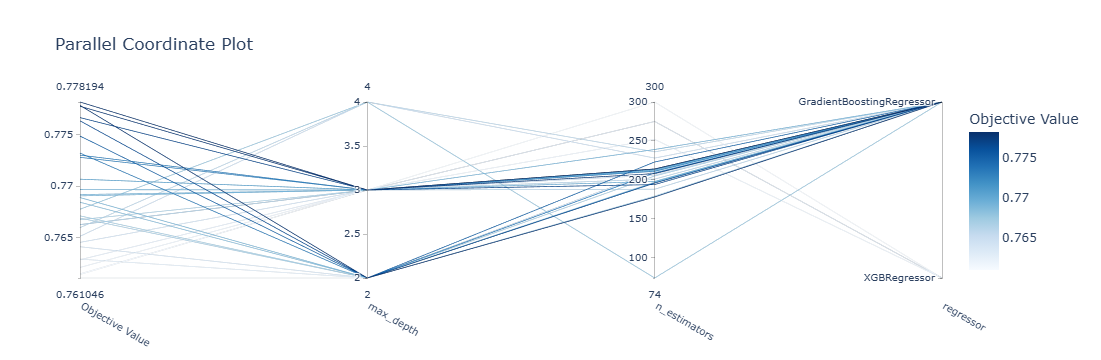

In [235]:
filtered_trials = [t for t in study.trials if t.value is not None and 0.76 <= t.value <= 0.8]
temp_study = optuna.create_study(direction=study.direction)
temp_study.add_trials(filtered_trials)

fig = plot_parallel_coordinate(temp_study, params=["regressor","n_estimators", "max_depth"])
show(fig)

In [239]:
regressor_name = study.best_params["regressor"]

regressor_dict = {
    "LinearRegression": LinearRegression,
    "RidgeRegression": Ridge,
    "LassoRegression": Lasso,
    "KNeighborsRegressor": KNeighborsRegressor,
    "RandomForestRegressor": RandomForestRegressor,
    "AdaBoostRegressor": AdaBoostRegressor,
    "GradientBoostingRegressor": GradientBoostingRegressor,
    "XGBRegressor": XGBRegressor
}

params_for_model = {k: v for k, v in study.best_params.items() if k !="regressor"}

regressor = regressor_dict[regressor_name](**params_for_model)

model_pipeline = Pipeline(steps=[
        ("model", TransformedTargetRegressor(
            regressor=regressor,
            transformer=FunctionTransformer(func=np.sqrt,inverse_func= lambda x:x**2)
        ))
    ])

model_pipeline.fit(X_train_preprocessed,y_train)
y_train_pred = model_pipeline.predict(X_train_preprocessed)
y_pred = model_pipeline.predict(X_val_preprocessed)

print(f'r2_scores for train and val are {r2_score(y_train,y_train_pred)} and {r2_score(y_val,y_pred)}')

r2_scores for train and val are 0.7771924753087592 and 0.7781620028543872
